In [11]:
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np

In [ ]:
username = "root"
password = "*******"
host = "localhost"
database = "new_schema"

DATABASE_URL = f"mysql+pymysql://{username}:{password}@{host}/{database}"
engine = create_engine(DATABASE_URL)

# Dataset Overview
We have access to the following tables in the database:

- Customers:
    - customer_id (INT): Unique identifier for each customer.
    - first_name (VARCHAR): Customer's first name.
    - last_name (VARCHAR): Customer's last name.
    - email (VARCHAR): Customer's email address.
    - sign_up_date (DATE): Date the customer signed up.
    - region (VARCHAR): Region where the customer is located.
- Orders:
    - order_id (INT): Unique identifier for each order.
    - customer_id (INT): Unique identifier for the customer who placed the order.
    - order_date (DATE): Date the order was placed.
    - order_status (VARCHAR): Status of the order (e.g., 'Completed', 'Pending', 'Canceled').
    - total_amount (DECIMAL): Total amount for the order.
- Products:
    - product_id (INT): Unique identifier for each product.
    - product_name (VARCHAR): Name of the product.
    - category (VARCHAR): Category of the product (e.g., 'Electronics', 'Clothing').
    - price (DECIMAL): Price of the product.
- OrderDetails:
    - order_id (INT): Unique identifier for the order.
    - product_id (INT): Unique identifier for the product.
    - quantity (INT): Quantity of the product ordered.

# Project Goal
The goal of this project is to illustrate the use of SQL queries for extracting information from data, followed by visualizing this data to uncover interesting patterns and insights.

1. We will identify the top 10 customers by total spending.

In [3]:
query = """
select
	o.customer_id
    ,concat(c.first_name, ' ', c.last_name) as "full_name"
    ,concat(o.customer_id, ": ", c.first_name, ' ', c.last_name) as "id_and_full_name"
    ,sum(o.total_amount) as "total_spending"
from orders as o
	left join customers c on c.customer_id = o.customer_id
group by o.customer_id
order by sum(o.total_amount) desc
limit 10
"""
df = pd.read_sql(text(query), con=engine)
df

,customer_id,full_name,id_and_full_name,total_spending
0,797,Anna Smith,797: Anna Smith,97356.52
1,469,Tom Doe,469: Tom Doe,97091.76
2,647,Tom Brown,647: Tom Brown,93569.79
3,750,Tom Brown,750: Tom Brown,91663.13
4,445,Anna Johnson,445: Anna Johnson,89147.04
5,367,Tom Miller,367: Tom Miller,83257.78
6,189,Anna Miller,189: Anna Miller,82424.24
7,146,Maria Miller,146: Maria Miller,78212.09
8,127,Maria Johnson,127: Maria Johnson,77386.99
9,643,Julia Miller,643: Julia Miller,77019.54


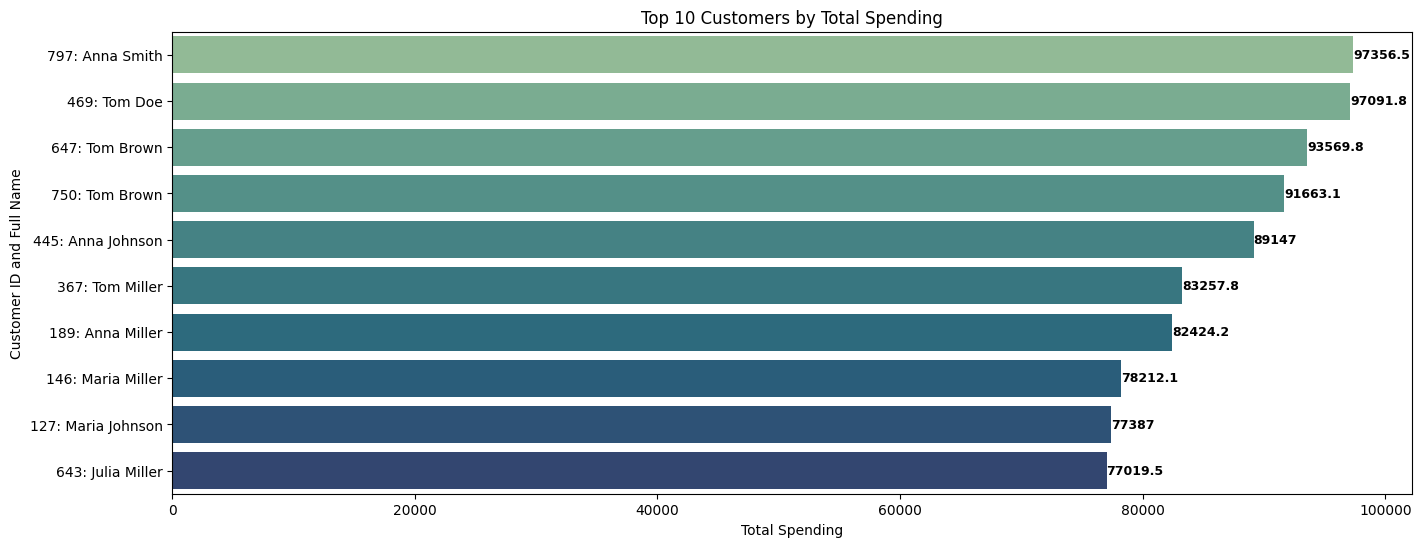

In [4]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=df, y="id_and_full_name", x="total_spending", hue = "id_and_full_name", palette="crest")

for container in ax.containers:
    ax.bar_label(container, color="black", fontsize=9, weight="bold")

plt.ylabel("Customer ID and Full Name")
plt.xlabel("Total Spending")
plt.title("Top 10 Customers by Total Spending")
plt.show()

2. We will group customers by region and analyze the total spending in each region.

In [124]:
query = """
select
    c.region
    ,sum(o.total_amount) as "total_spending"
from orders as o
	left join customers c on c.customer_id = o.customer_id
group by c.region
order by sum(o.total_amount) desc
"""
df = pd.read_sql(text(query), con=engine)
df

,region,total_spending
0,South,5932883.18
1,North,5847937.42
2,West,5715614.68
3,East,5526113.21


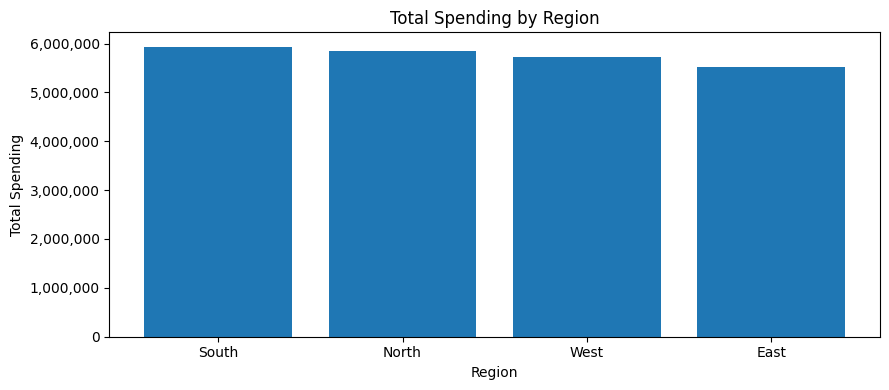

In [132]:
def format_y_axis(value, tick_position):
    return f'{value:,.0f}'

plt.figure(figsize=(9, 4))
plt.bar(df["region"], df["total_spending"])

plt.title("Total Spending by Region")
plt.xlabel("Region")
plt.ylabel("Total Spending")

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_y_axis))
plt.tight_layout()
plt.show()

3. We will analyze the monthly sales performance by calculating the total sales for each month in the last year.

In [97]:
query = """
select
	month(o.order_date) as "month"
    ,sum(o.total_amount) as "total sales"
from orders as o
where year(o.order_date) = 2024
group by month(o.order_date)
order by month(o.order_date) asc
"""
df = pd.read_sql(text(query), con=engine)
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df["month"] = df["month"].apply(lambda x: month_names[x-1])
df

,month,total sales
0,Apr,1096332.70
1,May,2188768.29
2,Jun,2048750.98
3,Jul,2004490.98
4,Aug,1925742.45
5,Sep,2126460.49
6,Oct,2009667.44
7,Nov,1798161.59
8,Dec,1896545.91


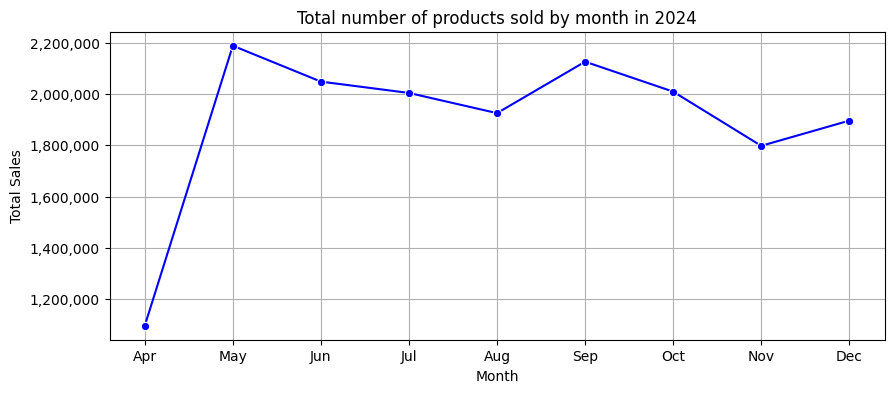

In [ ]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x="month", y="total sales", marker="o", color="b")

plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Total number of products sold by month in 2024")
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_axis))
plt.show()

4. We will check how much total sales and how many products were sold in each category.

In [100]:
query = """
select
    p.category
	,sum(p.price * od.quantity) as "total price"
    ,sum(od.quantity) as "number of product sold"
from orderdetails od
	left join products p on p.product_id = od.product_id
group by p.category
order by sum(p.price * od.quantity) desc
"""
df = pd.read_sql(text(query), con=engine)
df

,category,total price,number of product sold
0,Toys,7492734.54,12793.0
1,Books,6070810.08,10169.0
2,Clothing,6048351.55,11176.0
3,Electronics,3130227.68,6767.0


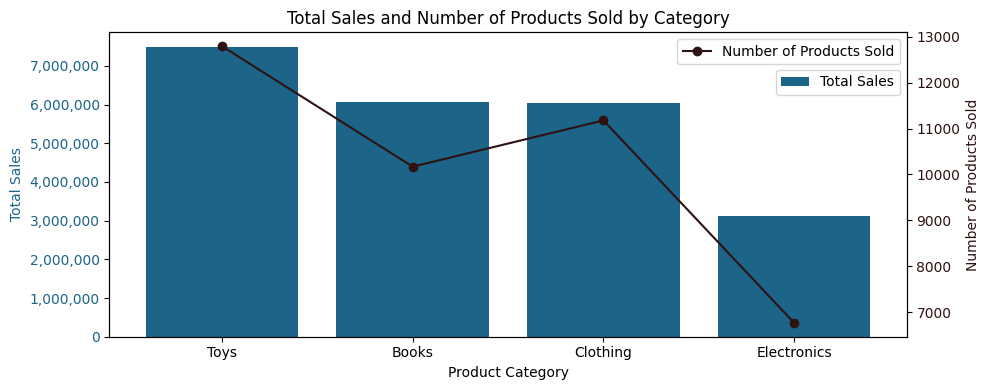

In [ ]:
categories = df["category"]
total_price = df["total price"]
product_count = df["number of product sold"]

fig, ax1 = plt.subplots(figsize=(10, 4))

palette = sns.color_palette("crest")
color = palette[4] 

ax1.bar(categories, total_price, label="Total Sales", color=color)

ax1.set_xlabel("Product Category")
ax1.set_ylabel("Total Sales", color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.yaxis.set_major_formatter(FuncFormatter(format_y_axis))

ax2 = ax1.twinx()
ax2.plot(categories, product_count, label="Number of Products Sold", color="#2E1111", marker='o')
ax2.set_ylabel("Number of Products Sold", color='#2E1111')
ax2.tick_params(axis='y', labelcolor='#2E1111')

ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.9)) 
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))  

plt.title("Total Sales and Number of Products Sold by Category")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


5. We will calculate the percentage of orders that were completed, canceled, or are still pending.

In [105]:
query = """
select
	o.order_status
    ,count(*) / (select count(*) from orders) "percentage"
from orders o
group by o.order_status
"""
df = pd.read_sql(text(query), con=engine)
df

,order_status,percentage
0,Pending,0.3252
1,Canceled,0.3352
2,Completed,0.3396


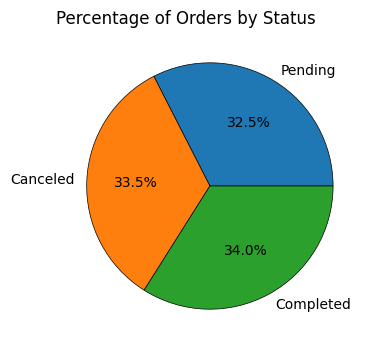

In [110]:
plt.figure(figsize=(11,4))
plt.pie(df["percentage"], labels = df["order_status"], autopct='%1.1f%%', wedgeprops=wedgeprops)
plt.title("Percentage of Orders by Status", loc='left')
plt.show()

6. We will analyze the average order value for completed orders, canceled orders, and pending orders.

In [112]:
query = """
select
	o.order_status
    ,avg(o.total_amount) avg
from orders o
group by o.order_status
"""
df = pd.read_sql(text(query), con=engine)
df

,order_status,avg
0,Pending,9020.282657
1,Canceled,9773.925919
2,Completed,8832.165807


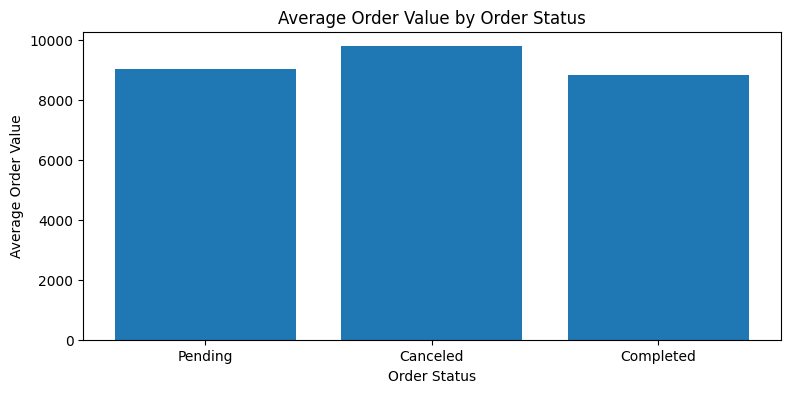

In [ ]:
plt.figure(figsize=(9, 4))
plt.bar(df["order_status"], df["avg"])

plt.title("Average Order Value by Order Status")
plt.xlabel("Order Status")
plt.ylabel("Average Order Value")

plt.show()

7. We will identify the top 5 best-selling products by quantity sold.

In [135]:
query = """
select
	p.product_id
    ,p.product_name
    ,sum(od.quantity) "quantity"
from orderdetails od
	left join products p on p.product_id = od.product_id
group by p.product_id
order by sum(od.quantity) desc
limit 5
"""
df = pd.read_sql(text(query), con=engine)
df

,product_id,product_name,quantity
0,37,Product 37,561.0
1,44,Product 44,553.0
2,36,Product 36,529.0
3,90,Product 90,492.0
4,24,Product 24,492.0


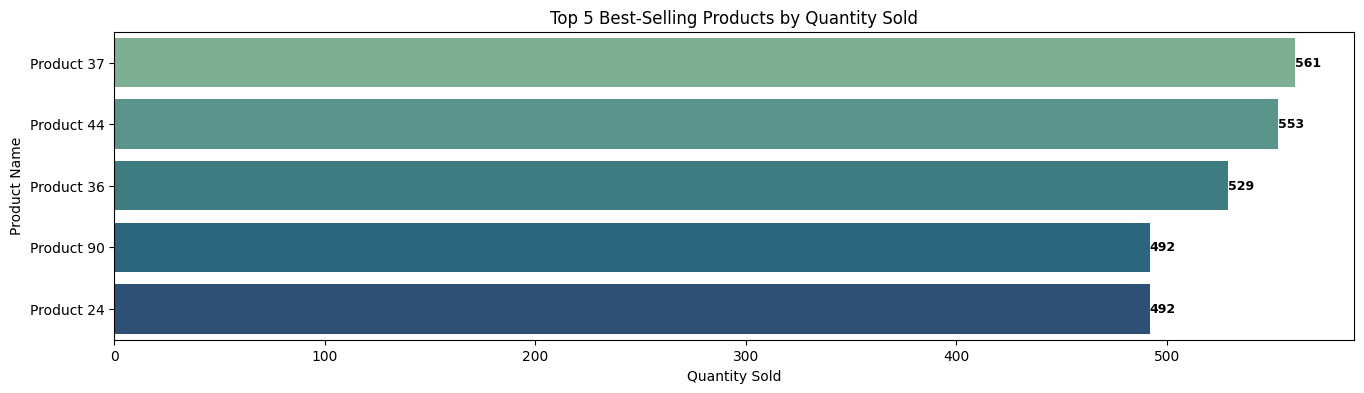

In [138]:
plt.figure(figsize=(16, 4))
ax = sns.barplot(data=df, y="product_name", x="quantity", hue = "product_name", palette="crest")

for container in ax.containers:
    ax.bar_label(container, color="black", fontsize=9, weight="bold")

plt.ylabel("Product Name")
plt.xlabel("Quantity Sold")
plt.title("Top 5 Best-Selling Products by Quantity Sold")
plt.show()